In [1]:
from edc import print_info
print_info("sh-data-access")


***Notebook Title***  
Sentinel Hub data access using xcube

***Notebook Description***  
Euro Data Cube Sentinel Hub - data access


***Notebook Dependencies***  
This notebook requires an active subscription to:
* EDC Sentinel Hub


In [2]:
from edc import check_compatibility
check_compatibility("user-2022.02", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


## EDC Sentinel Hub - data access using xcube

This notebook shows the various ways to open data cubes from Sentinel Hub (SH) for a given time range, region, and spatial resolution:

1. A **temporarily regular Sentinel-2 cube** with aggregated observations that fall into equal-size time periods;
2. A **temporarily irregular Sentinel-2 cube** which only includes time stamps where there were valid observations;
3. A cube using **projected coordinates**.

In [3]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [4]:
%matplotlib inline

In [5]:
import xcube
import xcube_sh

In [6]:
xcube_sh.__version__

'0.9.3'

In [7]:
xcube.__version__


'0.10.1'

---
For this demo, we are focussing on small coastal area near Kiel in Northern Germany (Baltic Sea)

In [8]:
x1 = 10.00  # degree
y1 = 54.27  # degree
x2 = 11.00  # degree
y2 = 54.60  # degree

bbox = x1, y1, x2, y2

Visualize the bounding box. If you don't see anything, please refer to EDC Setup example <a href="https://eurodatacube.com/marketplace/notebooks/curated/EDC_Sentinel_Hub-Setup" target="_blank">here</a>.

In [9]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is roughly 20 meters per pixel:

In [10]:
spatial_res = 0.00018   # = 20.038 meters in degree>

---
Example (!): Sentinel-2 L2A with aggregated observations that fall into equal-size `time_period` of 2 days:

In [11]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],
                         time_period='2D')

We define a `request_collector` as an observer for SH requests made, so we can show SH usage stats. This is a developer tool, useful for demonstration purposes too. **Otherwise, this is not needed.**

In [12]:
request_collector = Observers.request_collector()

Open a data cube:

In [13]:
cube = open_cube(cube_config, observer=request_collector)

In [14]:
cube

<xarray.Dataset>
Dimensions:    (time: 40, lat: 2048, lon: 5632, bnds: 2)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2022-06-23T10:16:51.857271
    time_coverage_start:       2018-05-14T00:00:00+00:00
    time_coverage_end:         2018-08-02T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        10.0
    geospatial_lat_min:        54.27
    geospatial_lon_max:        11.01376
    geospatial_lat_max:        54.63864
    processing_level:          L2A

No requests have been made yet. Requests are made only if data is actually required.

In [15]:
request_collector.stats

Note, the cube's time coordinates are monotonically increasing and the distance between two time steps is varying:

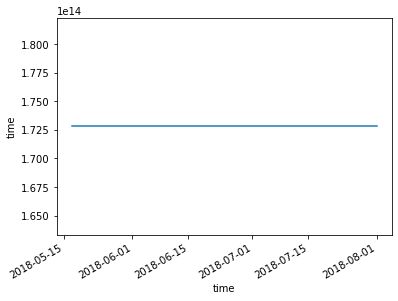

In [16]:
cube.time.diff(dim='time').plot.line()

In [17]:
cube.B04

,Array,Chunk
Bytes,1.72 GiB,1.00 MiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,1761 Tasks,1760 Chunks
Type,float32,numpy.ndarray


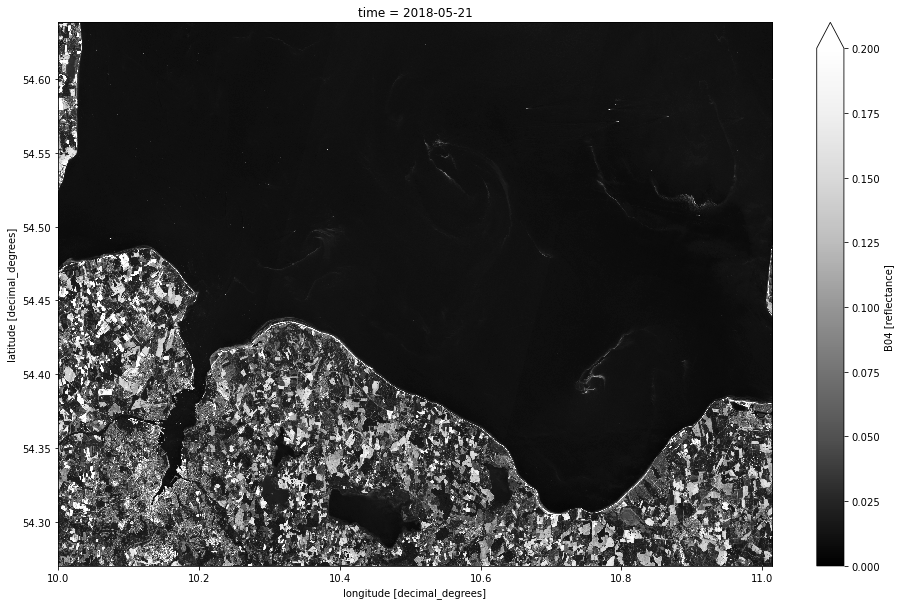

In [18]:
cube.B04.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(16, 10))

Now SentinelHub data requests have been made

In [19]:
request_collector.stats

Number of requests:,44
Request duration min:,308.87 ms
Request duration max:,1275.69 ms
Request duration median:,451.64 ms
Request duration mean:,518.20 ms
Request duration std:,218.46 ms


xcube mask sets also follow data cube structure

---
Example (2): Sentinel-2 L2A which only includes time stamps where there were valid observations for a given region. We use a `time_tolerance` of 30 minutes to decide whether scenes shall be combined:

In [20]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],                         
                         time_tolerance='30M')

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:148: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


In [21]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (time: 45, lat: 2048, lon: 5632, bnds: 2)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-29T10:30:19
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(45, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2022-06-23T10:17:17.528546
    time_coverage_start:     2018-05-15T10:30:24+00:00
    time_coverage_end:       2018-07-29T10:30:19+00:00
    time_coverage_duration:  P74DT23H59M55S
    geospatial_lon_min:      10.0
    geospatial_lat_min:      54.27
    geospatial_lon_max:      11.01376
    geospatial_lat_max:      54.63864
    processing_level:        L2A

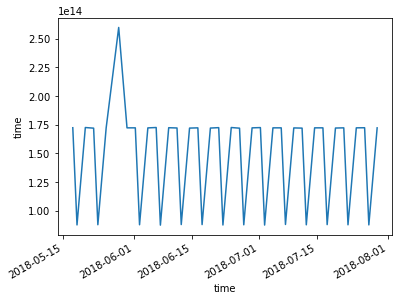

In [22]:
cube.time.diff(dim='time').plot.line()

---
Example (3): Using projected coordinates, setting the `crs` parameter to `'http://www.opengis.net/def/crs/EPSG/0/3857'` (EPSG:3857), that is Pseude-Mercato using a WGS-84 Ellisoid. Note that the spatial coordinates now switched from `lon`, `lat` to `x`, `y`. For other CRSes, refer to https://docs.sentinel-hub.com/api/latest/#/API/crs.

We need to provide the `bbox` and `spatial_res` parameters in EPSG:3857 units (meters) now, Ljubljana area: 

In [23]:
x1 = 1545577  # meters
y1 = 5761986  # meters
x2 = 1705367  # meters
y2 = 5857046  # meters

bbox = x1, y1, x2, y2

spatial_res = (x2 - x1) / 512  # meters

Verify we are right:

In [24]:
geom = shapely.geometry.box(*bbox)

import functools
import pyproj
import shapely.ops

project = functools.partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'),  # source coordinate system (Web Mercator)
    pyproj.Proj(init='epsg:4326'))  # destination coordinate system (WGS-84)

geom_wgs84 = shapely.ops.transform(project, geom)  # apply projection
IPython.display.GeoJSON(geom_wgs84.__geo_interface__)

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<IPython.display.GeoJSON object>

In [25]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         crs='http://www.opengis.net/def/crs/EPSG/0/3857',
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-01', '2018-05-10'],                         
                         time_period='1D')

In [26]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (time: 10, y: 305, x: 512, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-01T12:00:00 ... 2018-05-10T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(10, 2), meta=np.ndarray>
  * x          (x) float64 1.546e+06 1.546e+06 1.546e+06 ... 1.705e+06 1.705e+06
  * y          (y) float64 5.857e+06 5.857e+06 5.856e+06 ... 5.762e+06 5.762e+06
Dimensions without coordinates: bnds
Data variables:
    B04        (time, y, x) float32 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    B05        (time, y, x) float32 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    B06        (time, y, x) float32 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    B11        (time, y, x) float32 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    CLD        (time, y, x) uint8 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    SCL        (time, y, x) uint8 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    crs        int64 ...
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2022-06-23T10:17:18.662854
    time_coverage_start:       2018-05-01T00:00:00+00:00
    time_coverage_end:         2018-05-11T00:00:00+00:00
    time_coverage_duration:    P10DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    processing_level:          L2A

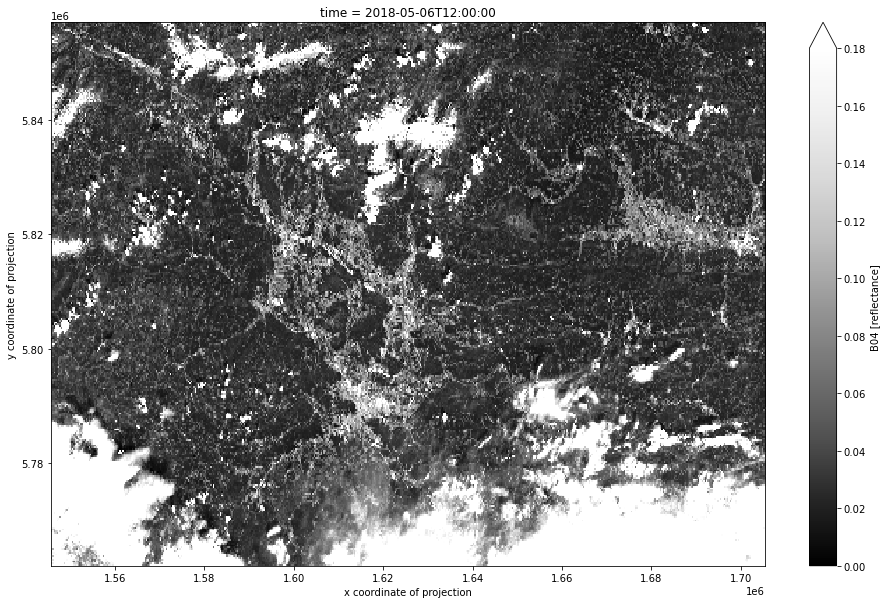

In [27]:
cube.B04.isel(time=5).plot.imshow(vmin=0, vmax=0.18, cmap='Greys_r', figsize=(16, 10))